In [19]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn

# Load data and create datasets

In [20]:
datastore = h5py.File('trials6.h5', 'r')
data_I = torch.tensor(datastore["I"])
data_params = torch.tensor(datastore["P"])
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")
data_I = data_I.to(device)
data_params = data_params.to(device)
dataset = TensorDataset(data_I, data_params)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using mps device


# Define the model

In [81]:
class VarTransform(nn.Module):
    def __init__(self):
        super(VarTransform, self).__init__()

    def forward(self, x):
        # exp of the 4th input value; pass others unchanged
        x[:, 3] = torch.exp(x[:, 3])
        return x

class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(101, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
        )
        self.output_transform = VarTransform()

    def forward(self, x):
        y = self.layers(x)
        y = self.output_transform(y)
        return y

In [82]:
model = net().to(device)
print(model)

net(
  (layers): Sequential(
    (0): Linear(in_features=101, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
  (output_transform): VarTransform()
)


## Test model on an input

In [83]:
model(next(iter(train_dataloader))[0])

tensor([[-0.0405, -0.0222,  0.0407,  1.0163],
        [-0.0399, -0.0245,  0.0407,  1.0127],
        [-0.0447, -0.0297,  0.0445,  1.0014],
        [-0.0417, -0.0229,  0.0411,  1.0170],
        [-0.0405, -0.0238,  0.0410,  1.0136],
        [-0.0404, -0.0241,  0.0413,  1.0142],
        [-0.0423, -0.0223,  0.0426,  1.0102],
        [-0.0441, -0.0239,  0.0411,  1.0119],
        [-0.0445, -0.0242,  0.0422,  1.0053],
        [-0.0423, -0.0228,  0.0389,  1.0144],
        [-0.0421, -0.0213,  0.0379,  1.0142],
        [-0.0418, -0.0224,  0.0407,  1.0169],
        [-0.0422, -0.0219,  0.0410,  1.0170],
        [-0.0439, -0.0235,  0.0404,  1.0129],
        [-0.0498, -0.0344,  0.0534,  1.0003],
        [-0.0419, -0.0218,  0.0409,  1.0165],
        [-0.0425, -0.0207,  0.0409,  1.0140],
        [-0.0403, -0.0239,  0.0415,  1.0174],
        [-0.0592, -0.0577,  0.0608,  0.9907],
        [-0.0401, -0.0239,  0.0416,  1.0166],
        [-0.0479, -0.0343,  0.0487,  0.9959],
        [-0.0433, -0.0242,  0.0419

# Training

In [84]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: Avg loss = {test_loss:>8f} \n")

In [85]:
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 150.067703  [   64/32000]
loss: 8.117894  [ 6464/32000]
loss: 13.442259  [12864/32000]
loss: 14.177588  [19264/32000]
loss: 7.886977  [25664/32000]
Test Error: Avg loss = 10.256440 

Epoch 2
-------------------------------
loss: 5.680380  [   64/32000]
loss: 4.025805  [ 6464/32000]
loss: 9.031260  [12864/32000]
loss: 5.030684  [19264/32000]
loss: 2.118362  [25664/32000]
Test Error: Avg loss = 4.500631 

Epoch 3
-------------------------------
loss: 3.046014  [   64/32000]
loss: 2.422184  [ 6464/32000]
loss: 3.088905  [12864/32000]
loss: 2.607656  [19264/32000]
loss: 2.784999  [25664/32000]
Test Error: Avg loss = 2.242556 

Epoch 4
-------------------------------
loss: 2.650748  [   64/32000]
loss: 0.975563  [ 6464/32000]
loss: 1.559389  [12864/32000]
loss: 1.554438  [19264/32000]
loss: 1.532409  [25664/32000]
Test Error: Avg loss = 1.627382 

Epoch 5
-------------------------------
loss: 2.820386  [   64/32000]
loss: 1.253068  [ 6464/32000]

# Inspecting results

In [86]:
model(data_I[10:16])

tensor([[ 1.1349e+01, -3.4761e-03,  1.7915e+00,  3.8139e-05],
        [ 1.9087e+01,  2.0554e-01,  2.0395e+00,  6.6299e-04],
        [ 2.6662e+01,  5.0118e-01,  2.2408e+00,  6.8067e-05],
        [ 3.4879e+01,  7.9988e-01,  2.5299e+00,  2.0273e-05],
        [ 4.8898e+00,  1.0562e+00,  2.4711e+00,  2.0854e-04],
        [ 1.2960e+01,  1.2587e+00,  2.6819e+00,  9.7381e-04]], device='mps:0',
       grad_fn=<CopySlices>)

In [87]:
data_params[10:16]

tensor([[1.1236e+01, 2.4793e-02, 1.9412e+00, 4.4138e-04],
        [1.9226e+01, 2.9752e-01, 2.1176e+00, 4.7241e-04],
        [2.7216e+01, 5.7025e-01, 2.2941e+00, 5.0345e-04],
        [3.5206e+01, 8.4298e-01, 2.4706e+00, 5.3448e-04],
        [4.8440e+00, 1.1157e+00, 2.6471e+00, 5.6552e-04],
        [1.2834e+01, 1.3884e+00, 2.8235e+00, 5.9655e-04]], device='mps:0')

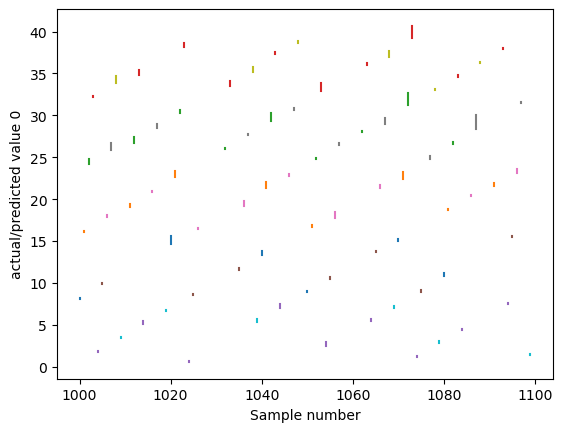

In [88]:
with torch.no_grad():
    pred = model(data_I).cpu().numpy()
r = range(1000, 1100)
plt.plot(np.vstack((r,r)), np.vstack((data_params[r, 0].cpu().numpy(), pred[r, 0])));
plt.xlabel("Sample number")
plt.ylabel("actual/predicted value 0")
plt.show()